In [1]:
import numpy as np
from nltk import edit_distance
import pandas as pd
from sklearn.cluster import HDBSCAN
from transformers import BertForMaskedLM, BertTokenizer, pipeline, T5Tokenizer, T5EncoderModel
import re
import torch
import matplotlib.pyplot as plt
import umap
import json

/home/ubuntu/anaconda3/envs/BA24/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1. take dataset 
2. take current row 
3. split it into: 
    - CDR3, V, J 
    - Epitope, MHC A, MHC B, MHC class 
4. take next (random) row (or for each)
5. split it into: 
    - CDR3, V, J 
    - Epitope, MHC A, MHC B, MHC class
6. compute levenshtein distance for: 
    - CDR3 region (row A to row B)
    - Epitopes (row A to row B)
7. if they are NOT to similar => search new row B 

In [2]:
read_path_beta = "../data/customDatasets/beta_concatenated.tsv"
beta_df = pd.read_csv(read_path_beta, sep="\t")

/tmp/ipykernel_4556/624418882.py:2: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  beta_df = pd.read_csv(read_path_beta, sep="\t")


In [3]:
beta_df

,TCR_name,TRAV,TRAJ,TRA_CDR3,TRBV,TRBJ,TRB_CDR3,TRAC,TRBC,TRA_leader,...,TRA_5_prime_seq,TRA_3_prime_seq,TRB_5_prime_seq,TRB_3_prime_seq,Epitope,Score_TRA,Score_TRB,MHC A,MHC B,MHC class
0,1,NaN,NaN,NaN,TRBV13*01,TRBJ1-5*01,CASSYLPGQGDHYSNQPQHF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,FLKEKGGL,NaN,2.0,HLA-B*08,B2M,MHCI
1,2,NaN,NaN,NaN,TRBV13*01,TRBJ1-5*01,CASSFEAGQGFFSNQPQHF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,FLKEKGGL,NaN,2.0,HLA-B*08,B2M,MHCI
2,3,NaN,NaN,NaN,TRBV13*01,TRBJ1-5*01,CASSFEPGQGFYSNQPQHF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,FLKEKGGL,NaN,2.0,HLA-B*08,B2M,MHCI
3,4,NaN,NaN,NaN,TRBV13*01,TRBJ1-5*01,CASSYEPGQVSHYSNQPQHF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,FLKEKGGL,NaN,2.0,HLA-B*08,B2M,MHCI
4,5,NaN,NaN,NaN,TRBV14*01,TRBJ2-1*01,CASSALASLNEQFF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,FLKEKGGL,NaN,2.0,HLA-B*08,B2M,MHCI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53306,53307,TRAV25,TRAJ28,CAGSGAGSYQLTF,NaN,NaN,CASSLEGQASSYEQYF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,CLGGLLTMV,NaN,NaN,NaN,NaN,NaN
53307,53308,TRAV25,TRAJ28,CAGLGAGSYQLTF,NaN,NaN,CASSLEGQGASYEQYF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,CLGGLLTMV,NaN,NaN,NaN,NaN,NaN
53308,53309,TRAV17*01,TRAJ11*01,CATEGNSGYSTLTF,NaN,NaN,CASSSQGGNYGYTF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,FLYALALLL,NaN,NaN,NaN,NaN,NaN
53309,53310,TRAV17*01,TRAJ11*01,CATEGDSGYSTLTF,NaN,NaN,CASSYQGGNYGYTF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,FLYALALLL,NaN,NaN,NaN,NaN,NaN


In [4]:
print(beta_df["TCR_name"].to_string())

0            1
1            2
2            3
3            4
4            5
5            6
6            7
7            8
8            9
9           10
10          11
11          12
12          13
13          14
14          15
15          16
16          17
17          18
18          19
19          20
20          21
21          22
22          23
23          24
24          25
25          26
26          27
27          28
28          29
29          30
30          31
31          32
32          33
33          34
34          35
35          36
36          37
37          38
38          39
39          40
40          41
41          42
42          43
43          44
44          45
45          46
46          47
47          48
48          49
49          50
50          51
51          52
52          53
53          54
54          55
55          56
56          57
57          58
58          59
59          60
60          61
61          62
62          63
63          64
64          65
65          66
66        

In [5]:
max_index = len(beta_df) - 1 
negative_epitopes = []
leven_threshold = 4 # this number is a magic number... 
#if we use a too high one only a few epitopes (the longer ones) can be potentially choosed. 
# This because only for the longer epitopes the levenshtein distance can then be matched

In [6]:
def search_negative_epitope(df, index):
    df = df
    index = index
    epitope = df["Epitope"][index]
    # print(epitope)
    random_epitope_index = np.random.randint(0, max_index)
    random_epitope = df["Epitope"][random_epitope_index]
    leven_dist = edit_distance(epitope, random_epitope)

    if(leven_dist >= leven_threshold): 
        negative_epitopes.append(random_epitope)
    else: 
        search_negative_epitope(df, index)

In [7]:
'''
for i, epitope in enumerate(beta_df["Epitope"]): 
    search_negative_epitope(beta_df, i)
'''

'\nfor i, epitope in enumerate(beta_df["Epitope"]): \n    search_negative_epitope(beta_df, i)\n'

In [8]:
negative_epitopes_df = pd.DataFrame(negative_epitopes, columns=["Negative Epitope"])
negative_epitopes_df

,Negative Epitope


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

I (CG) think that this is a bit hacky, this beacuase we compare sequences with different length and the Levenshtein distance is designed to compare strings from the same length...

Idea: create embedding of epitope and measure similarity of them or cluster them...

The output dimensions from [ProtBert on HuggingFace](https://huggingface.co/Rostlab/prot_bert) seems wrong in my opinion... => not wrong but somehow not usable directly as a representation. After elaborating i saw that in the [GitHub Repo of the ProtTrans](https://github.com/agemagician/ProtTrans/tree/master?tab=readme-ov-file#models) they promote another, better performing model called ProtT5.

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device: {}".format(device))

Using device: cpu


In [10]:
#@title Load encoder-part of ProtT5 in half-precision. { display-mode: "form" }
# Load ProtT5 in half-precision (more specifically: the encoder-part of ProtT5-XL-U50 in half-precision)
transformer_link = "Rostlab/prot_t5_xl_half_uniref50-enc"
print("Loading: {}".format(transformer_link))
model = T5EncoderModel.from_pretrained(transformer_link)
if device==torch.device("cpu"):
  print("Casting model to full precision for running on CPU ...")
  model.to(torch.float32) # only cast to full-precision if no GPU is available
model = model.to(device)
model = model.eval()
tokenizer = T5Tokenizer.from_pretrained(transformer_link, do_lower_case=False, legacy=True )

Loading: Rostlab/prot_t5_xl_half_uniref50-enc
Casting model to full precision for running on CPU ...


## CONSIDER THIS:
Maybe instead of just passing the Epitope we should also pass the MHC information available.. This because in my opinion if I pass the same epitope I should theoretically always get the same embedding, right? => After consideration: This is in my opinion not feasible as the PLMs only want AA sequences as input (?)

In [11]:
epitopes = set(beta_df["Epitope"].to_list())

In [12]:
# this will replace all rare/ambiguous amino acids by X and introduce white-space between all amino acids
processed_epitopes = [(sequence, " ".join(list(re.sub(r"[UZOB]", "X", sequence)))) for sequence in epitopes]
# processed_epitopes

In [13]:
def process_batch(processed_seqs):
    # Extract just the processed sequences for tokenization
    sequences = [seq[1] for seq in processed_seqs]
    ids = tokenizer.batch_encode_plus(sequences, add_special_tokens=True, padding="longest", return_tensors="pt")
    input_ids = ids['input_ids'].to(device)
    attention_mask = ids['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
    last_hidden_states = outputs.last_hidden_state
    
    # Now, return embeddings mapped to the original sequence
    embeddings = {}
    for i, (original_seq, _) in enumerate(processed_seqs):
        seq_len = attention_mask[i].sum().item() - 2  # Subtract [CLS] and [SEP]
        valid_embeddings = last_hidden_states[i, 1:seq_len+1]
        mean_embedding = valid_embeddings.mean(dim=0)
        embeddings[original_seq] = mean_embedding.cpu().numpy()  # Use original sequence as key
    
    return embeddings

In [14]:
'''
batch_size = 128 
sequence_to_embedding = {}

# Batch processing with a dictionary, using original sequences as keys
for i in range(0, len(processed_epitopes), batch_size):
    batch_sequences = processed_epitopes[i:i+batch_size]
    batch_embeddings = process_batch(batch_sequences)
    sequence_to_embedding.update(batch_embeddings)
'''

In [15]:
# sequence_to_embedding

In [16]:
'''
beta_df["Epitope Embedding"] = beta_df["Epitope"].map(sequence_to_embedding)
beta_df
'''

,TCR_name,TRAV,TRAJ,TRA_CDR3,TRBV,TRBJ,TRB_CDR3,TRAC,TRBC,TRA_leader,...,TRA_3_prime_seq,TRB_5_prime_seq,TRB_3_prime_seq,Epitope,Score_TRA,Score_TRB,MHC A,MHC B,MHC class,Epitope Embedding
0,1,NaN,NaN,NaN,TRBV13*01,TRBJ1-5*01,CASSYLPGQGDHYSNQPQHF,NaN,NaN,NaN,...,NaN,NaN,NaN,FLKEKGGL,NaN,2.0,HLA-B*08,B2M,MHCI,"[0.08082557, 0.018622547, -0.062810875, -0.115..."
1,2,NaN,NaN,NaN,TRBV13*01,TRBJ1-5*01,CASSFEAGQGFFSNQPQHF,NaN,NaN,NaN,...,NaN,NaN,NaN,FLKEKGGL,NaN,2.0,HLA-B*08,B2M,MHCI,"[0.08082557, 0.018622547, -0.062810875, -0.115..."
2,3,NaN,NaN,NaN,TRBV13*01,TRBJ1-5*01,CASSFEPGQGFYSNQPQHF,NaN,NaN,NaN,...,NaN,NaN,NaN,FLKEKGGL,NaN,2.0,HLA-B*08,B2M,MHCI,"[0.08082557, 0.018622547, -0.062810875, -0.115..."
3,4,NaN,NaN,NaN,TRBV13*01,TRBJ1-5*01,CASSYEPGQVSHYSNQPQHF,NaN,NaN,NaN,...,NaN,NaN,NaN,FLKEKGGL,NaN,2.0,HLA-B*08,B2M,MHCI,"[0.08082557, 0.018622547, -0.062810875, -0.115..."
4,5,NaN,NaN,NaN,TRBV14*01,TRBJ2-1*01,CASSALASLNEQFF,NaN,NaN,NaN,...,NaN,NaN,NaN,FLKEKGGL,NaN,2.0,HLA-B*08,B2M,MHCI,"[0.08082557, 0.018622547, -0.062810875, -0.115..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53306,53307,TRAV25,TRAJ28,CAGSGAGSYQLTF,NaN,NaN,CASSLEGQASSYEQYF,NaN,NaN,NaN,...,NaN,NaN,NaN,CLGGLLTMV,NaN,NaN,NaN,NaN,NaN,"[0.17118011, 0.015042233, -0.16186884, -0.1314..."
53307,53308,TRAV25,TRAJ28,CAGLGAGSYQLTF,NaN,NaN,CASSLEGQGASYEQYF,NaN,NaN,NaN,...,NaN,NaN,NaN,CLGGLLTMV,NaN,NaN,NaN,NaN,NaN,"[0.17118011, 0.015042233, -0.16186884, -0.1314..."
53308,53309,TRAV17*01,TRAJ11*01,CATEGNSGYSTLTF,NaN,NaN,CASSSQGGNYGYTF,NaN,NaN,NaN,...,NaN,NaN,NaN,FLYALALLL,NaN,NaN,NaN,NaN,NaN,"[0.15087421, 0.048422594, -0.12238953, -0.1389..."
53309,53310,TRAV17*01,TRAJ11*01,CATEGDSGYSTLTF,NaN,NaN,CASSYQGGNYGYTF,NaN,NaN,NaN,...,NaN,NaN,NaN,FLYALALLL,NaN,NaN,NaN,NaN,NaN,"[0.15087421, 0.048422594, -0.12238953, -0.1389..."


In [17]:
# This is needed becuase the ebedding is huge and otherwise it would be stored with line breaks (\n) 
# This would make it difficult while reading the file
beta_df['Epitope Embedding'] = beta_df['Epitope Embedding'].apply(lambda x: json.dumps(x.tolist()))

In [18]:
to_path = "../data/customDatasets/negative_samples/temp"
file_name = "beta_epitope_embeddings.tsv"
beta_df.to_csv(to_path+"/"+file_name, sep="\t", index=False)

In [19]:
beta_df = pd.read_csv(to_path+"/"+file_name, sep="\t")
beta_df['Epitope Embedding'] = beta_df['Epitope Embedding'].apply(lambda x: np.array(json.loads(x)))

/tmp/ipykernel_4556/679740710.py:1: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  beta_df = pd.read_csv(to_path+"/"+file_name, sep="\t")


In [ ]:
print(beta_df["Epitope Embedding"].to_string())

In [21]:
# here use a set of the embeddings because many duplicates as same epitopes
# Do so becuase very slow if every embedding is processed 
umap_embeddings = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(beta_df["Epitope Embedding"].to_list())

/home/ubuntu/anaconda3/envs/BA24/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
# use PCA as well for completeness

/tmp/ipykernel_4556/2798666352.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=0.1, cmap='Spectral');


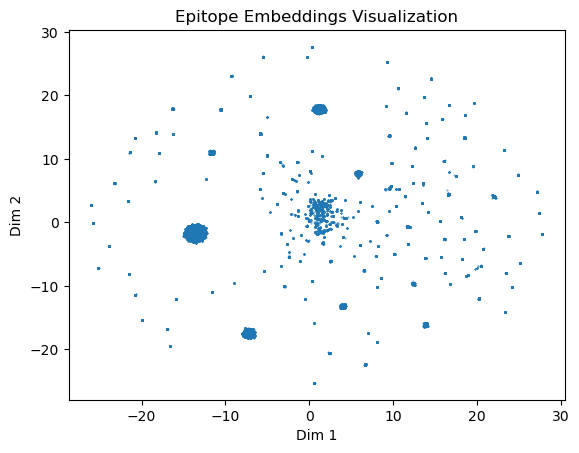

In [22]:
plt.title("Epitope Embeddings Visualization")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=0.1, cmap='Spectral');

In [ ]:
hdb = HDBSCAN(
    min_cluster_size=5, 
    min_samples=5)
hdb.fit(umap_embeddings)

labels = hdb.labels_

In [ ]:
'''
clustered = (labels >= 0)
plt.title("Epitope Clustering Visualization")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.scatter(umap_embeddings[~clustered, 0],
            umap_embeddings[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(umap_embeddings[clustered, 0],
            umap_embeddings[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral');
'''

In [ ]:
# Assuming umap_embeddings and labels are defined
clustered = (labels >= 0)

plt.figure(figsize=(10, 8))  # Optional: Adjust figure size
plt.title("Epitope Clustering Visualization")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")

# Plot points not belonging to any cluster
plt.scatter(umap_embeddings[~clustered, 0], umap_embeddings[~clustered, 1], color='gray', s=0.1, alpha=0.5, label='Noise')

# Plot points for each cluster with a unique color and label
unique_labels = np.unique(labels[clustered])
for label in unique_labels:
    # Select data points belonging to the current cluster
    points = umap_embeddings[labels == label]
    plt.scatter(points[:, 0], points[:, 1], s=0.1, cmap='Spectral', label=f'Cluster {label}')

plt.legend(markerscale=10, title="Clusters")  # Adjust markerscale as needed for visibility
plt.show()

In [ ]:
beta_df["HDBSCAN Label"] = labels

In [ ]:
beta_df["HDBSCAN Label"]

In [ ]:
to_path = "../data/customDatasets/negative_samples/temp"
file_name = "beta_epitope_embeddings.tsv"
beta_df.to_csv(to_path+"/"+file_name, sep="\t", index=False)

criterias to be a nagative sample for an epitope: 
1. check if epitope is in same cluster 
2. if not: take this epitope as negative sample 

=> I (CG) do not highly trust the clustering... maybe we can combine it with the levenshtein approach? so: 

    if not in cluster AND levenshtein >= x, where x is a random number in an interval